# A. Магазины (диагностика технических навыков - аналитика)
* Ограничение времени	1 секунда
* Ограничение памяти	64.0 Мб
* Ввод	
* Вывод	стандартный вывод

Вам доступны данные о помесячной выручке сети магазинов Диэлектрик. Данные хранятся в таблице со схемой

`CREATE TABLE revenue_data (
  shop_id integer NOT NULL,
  city text NOT NULL,
  month text NOT NULL,
  revenue integer NOT NULL
);`

Необходимо для каждого города найти top-3 магазина с наибольшей выручкой **без учета магазинов с суммарной выручкой меньше 120**. Для выбранных магазинов также нужно вычислить долю их выручки в суммарной выручке **всех** магазинов того же города. Долю округлить до целого числа процентов.

В результате у вас должно получиться 3 колонки: `city`, `shop_id`, `city_revenue_share`.
Результат должен быть упорядочен по:
* 1) названию города (city) в лексикографическом порядке;
* 2) доле выручки в городе (city_revenue_share) от наибольшей к наименьшей;
* 3) идентификатору магазина (shop_id) в порядке возрастания.

**Примечания**
Ввод и вывод в данной задаче реализуются через отправку запроса к БД

*Загрузить пример базы данных и правильного ответа*

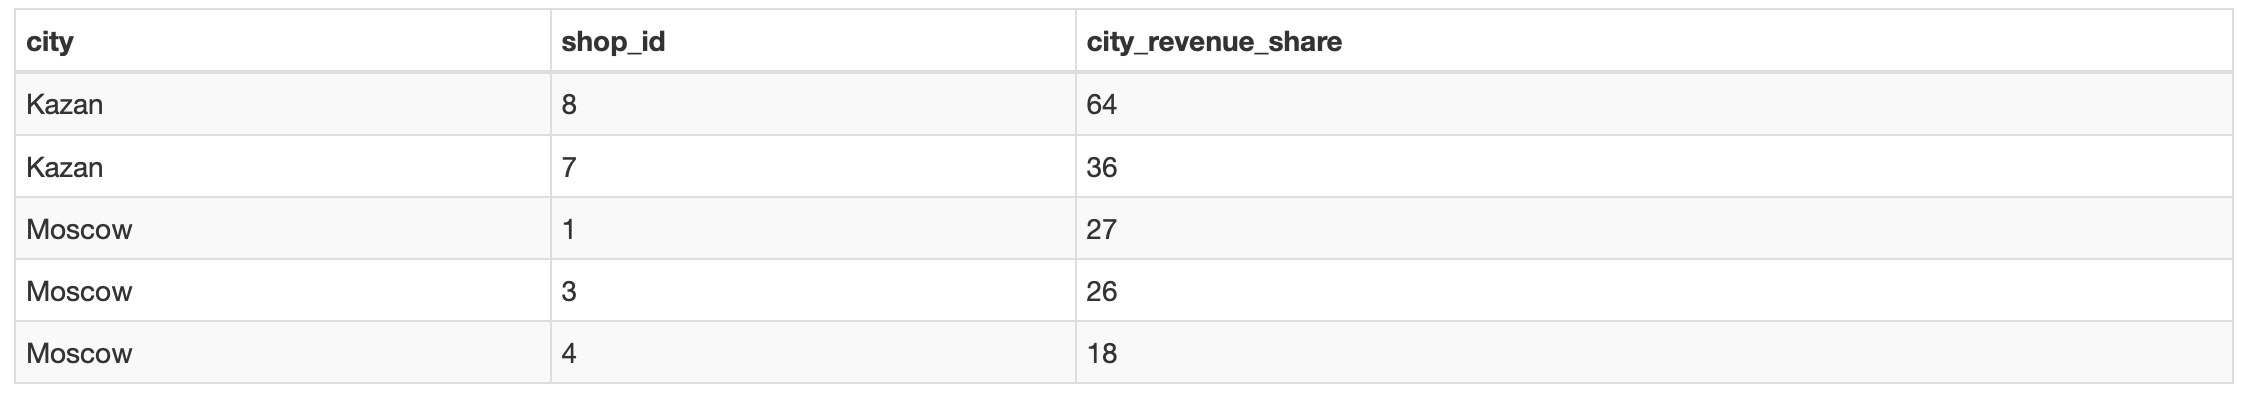

Типом выходного поля city_revenue_share должен быть REAL, несмотря на то, что на скриншоте из примера в этом поле отображаются целые числа

# Решение

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# variant 1 - reading all data from db in the pandas dataset (memory extensive but simplest)

engine = create_engine('sqlite:///sample-db.db', echo=False)
query = '''
            SELECT * FROM revenue_data
        '''
revenue_df = pd.io.sql.read_sql(query, con = engine)

#-------------------------------------------------
# aggregating revenues by shops into new dataframe

shop_revenue_df = revenue_df.groupby(['shop_id','city'], as_index = False).agg({'revenue':'sum'})

#------------------------------------------------------------------------------
# adding to the dataframe the field with the total revenue share for given city

shop_revenue_df['city_revenue'] = shop_revenue_df[['city','revenue']].groupby('city').transform(sum)

#-----------------------------------------------------------------------------
# calculating city revenue share for each shop as a new field of the dataframe

shop_revenue_df['city_revenue_share'] = round( shop_revenue_df['revenue'] / shop_revenue_df['city_revenue'] * 100 )

#--------------------------------------------------------------------------------
# filtering black listed shops with the total shop revenue < 120 out of dataframe

shop_revenue_df = shop_revenue_df.query('revenue >= 120')

#----------------------------------------------------------------
# adding shop rank field by revenue in each city to the dataframe

shop_revenue_df['shop_rank_in_city'] = shop_revenue_df.groupby('city')['revenue'].rank(ascending =- False)

#----------------------------------------------------------------
# preparing output dataframe

show_df = shop_revenue_df.query('shop_rank_in_city < 4').sort_values(['city', 'city_revenue_share', 'shop_id'], 
          ascending = [True, False, True]).reset_index(drop=True)[['city', 'shop_id', 'city_revenue_share']]

# delivering output: 
print(show_df)

#show_df.to_sql('output', con = engine, if_exists='replace', index=False)

#pd.io.sql.read_sql('SELECT * FROM output', con = engine)

     city  shop_id  city_revenue_share
0   Kazan        8                64.0
1   Kazan        7                36.0
2  Moscow        1                27.0
3  Moscow        3                26.0
4  Moscow        4                18.0
